In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

/bin/bash: python: command not found
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
/bin/bash: python: command not found
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [154]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import csv
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.24.0
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/monai/jupyter/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/lat

In [155]:
os.environ["MONAI_DATA_DIRECTORY"] = 'data/'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
image_dir = root_dir + 'pneumoniamnist/'
print(root_dir)
print(os.getcwd())

data/
/home/monai/MedNIST


In [156]:
# dataset downloaded via cli
# https://github.com/MedMNIST/MedMNIST
# python -m medmnist download --root=.
# python -m medmnist save --flag=pneumoniamnist --root=. --folder=. --postfix=png

In [157]:
set_determinism(seed=0)


In [158]:
train = 'TRAIN'
validation = 'VALIDATION'
test= 'TEST'

none = 'none'
pneumonia = 'pneumonia'
class_names = [none, pneumonia]

num_class=2

files = {
    train: [],
    validation: [],
    test: []
}

labels = {
    train: [],
    validation: [],
    test: []
}
with open(root_dir + 'pneumoniamnist.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      #  label = none if row[2] == '0' else pneumonia
        files[row[0]].append(image_dir + row[1])
        labels[row[0]].append(int(row[2]))
image_width, image_height = PIL.Image.open(files[train][0]).size


print(f"Image dimensions: {image_width} x {image_height}")
print(len(files[train]))
print(len(labels[train]))
print(len(files[validation]))
print(len(labels[validation]))
print(len(files[test]))
print(len(labels[test]))

print(files[train][1200])
print(labels[train][1200])

Image dimensions: 28 x 28
4708
4708
524
524
624
624
data/pneumoniamnist/train1200_1.png
1


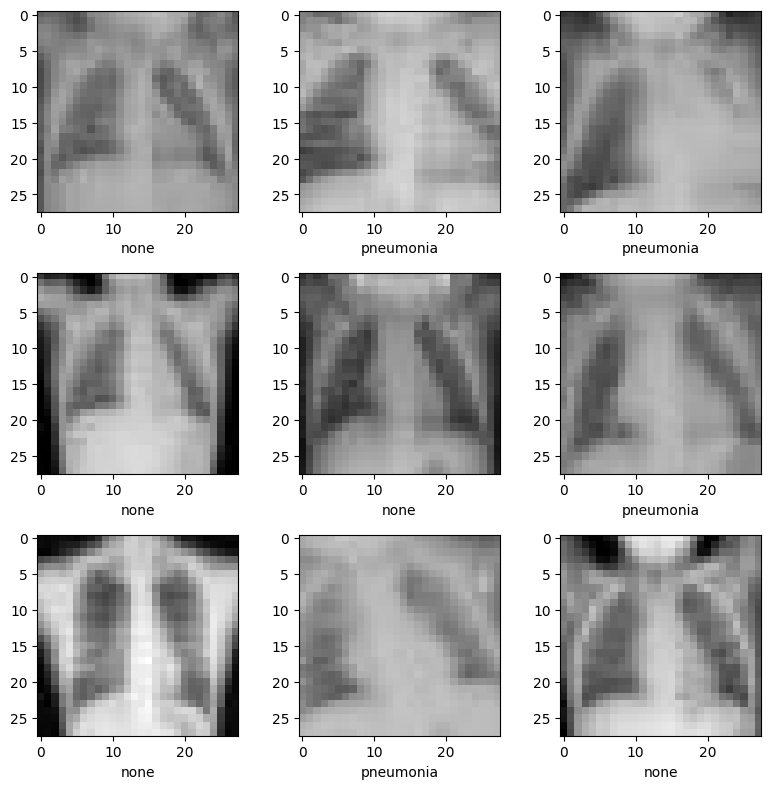

In [159]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(files[train]), size=9)):
    im = PIL.Image.open(files[train][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(pneumonia if labels[train][k] == 1 else none)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [160]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize([64, 64]),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        EnsureChannelFirst(), 
        ScaleIntensity(),
        Resize([64, 64]),
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [161]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(files[train], labels[train], train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=30, shuffle=True, num_workers=8)

val_ds = MedNISTDataset(files[validation], labels[validation], val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=8)

test_ds = MedNISTDataset(files[test], labels[test], val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=8)

In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [163]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/156, train_loss: 0.6816
2/156, train_loss: 0.6714
3/156, train_loss: 0.6740
4/156, train_loss: 0.6482
5/156, train_loss: 0.6783
6/156, train_loss: 0.6554
7/156, train_loss: 0.6755
8/156, train_loss: 0.6521
9/156, train_loss: 0.6202
10/156, train_loss: 0.6334
11/156, train_loss: 0.6288
12/156, train_loss: 0.6284
13/156, train_loss: 0.6377
14/156, train_loss: 0.6147
15/156, train_loss: 0.6119
16/156, train_loss: 0.6049
17/156, train_loss: 0.6116
18/156, train_loss: 0.6259
19/156, train_loss: 0.6023
20/156, train_loss: 0.5753
21/156, train_loss: 0.6252
22/156, train_loss: 0.5923
23/156, train_loss: 0.5867
24/156, train_loss: 0.5836
25/156, train_loss: 0.5500
26/156, train_loss: 0.5877
27/156, train_loss: 0.5516
28/156, train_loss: 0.5877
29/156, train_loss: 0.5858
30/156, train_loss: 0.5308
31/156, train_loss: 0.5897
32/156, train_loss: 0.5364
33/156, train_loss: 0.5227
34/156, train_loss: 0.5665
35/156, train_loss: 0.5408
36/156, train_loss: 0.5299
37/156, train_l

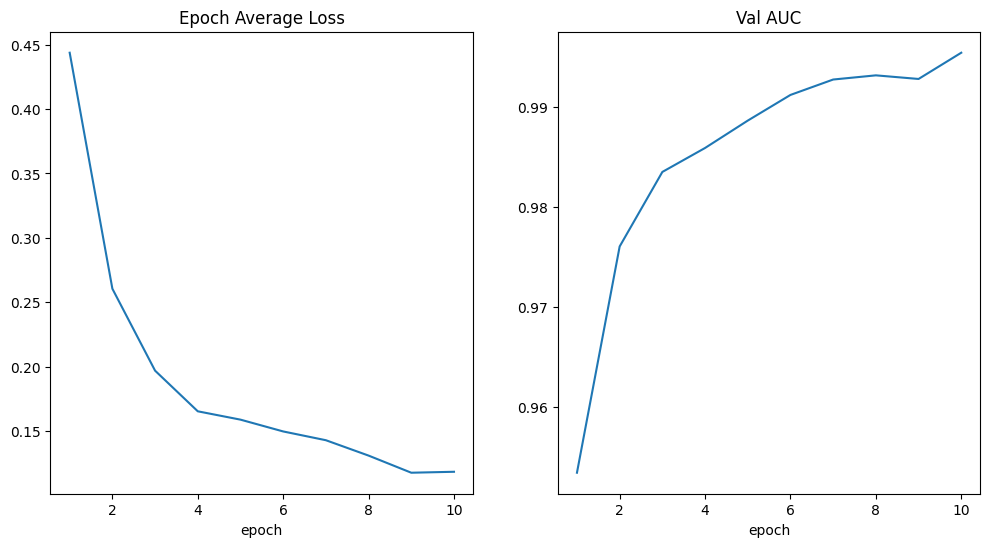

In [164]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [165]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [166]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        none     0.9464    0.6795    0.7910       234
   pneumonia     0.8355    0.9769    0.9007       390

    accuracy                         0.8654       624
   macro avg     0.8910    0.8282    0.8459       624
weighted avg     0.8771    0.8654    0.8596       624



In [167]:
print(os.path.join(root_dir, "best_metric_model.pth"))

data/best_metric_model.pth


In [169]:
torch.jit.script(model).save(root_dir + "classifier.zip")